In [9]:
import random
import gym
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

from collections import deque

import matplotlib.pyplot as plt

from IPython.display import clear_output

In [6]:
class DQN:
    def __init__(self, env, learning_rate, activation):
        self.state_size = env.observation_space.shape
        self.action_size = env.action_space.n
        self.model = self.create_model(learning_rate, activation)
    
    def create_model(self, learning_rate, activation):
        model = Sequential()
        model.add(Dense(32, input_dim=self.state_size[0], activation="relu"))
        model.add(Dense(64, activation="relu"))
        model.add(Dense(self.action_size, activation=activation))
        model.compile(loss="mse", optimizer=Adam(lr=learning_rate))
        return model
    
    def load(self, name):
        self.model.load_weights(name)
    
    def save(self, name):
        self.model.save_weights(name)

In [3]:
class Agent:
    def __init__(self, model, learning_rate, discount, epsilon, epsilon_min, epsilon_decay):
        self.memory = deque(maxlen=10000)
        self.model = model
        self.learning_rate = learning_rate
        self.discount = discount
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append([state, action, reward, next_state, done])
    
    def choose_action(self, state, action_size):
        if np.random.random() <= self.epsilon:
            return np.random.randint(action_size)
        return np.argmax(self.model.predict(state)[0])
    
    def replay(self, batch_size):
        experience = random.sample(self.memory, batch_size)
        
        for state, action, reward, next_state, done in experience:
            target = reward
            if not done:
                target = reward + self.discount * np.max(self.model.predict(next_state)[0])
            target_ = self.model.predict(state)
            target_[0][action] = target
            self.model.fit(state, target_, verbose=0)
        
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


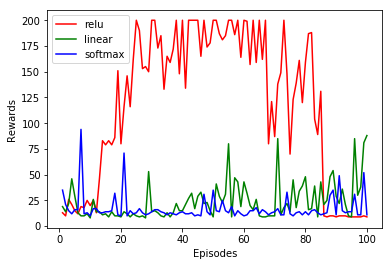

In [51]:
env = gym.make('CartPole-v0')

learning_rate = 0.001
discount = 0.95
epsilon = 1.0
epsilon_min = 0.001
epsilon_decay = 0.995

batch_size = 64


def play(activation, color, episodes=100, plot=True):
    network = DQN(env, learning_rate, activation)
    model = network.model
    agent = Agent(model, learning_rate, discount, epsilon, epsilon_min, epsilon_decay)
    
    total_rewards = []
    total_episodes = []
    done = False
    
    print(f"Playing with activation {activation}")
    
    for episode in range(1, episodes+1):
        rewards = 0
        state = env.reset().reshape(1, env.observation_space.shape[0])

        while True:
            action = agent.choose_action(state, env.action_space.n)
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, env.observation_space.shape[0]])
            agent.remember(state, action, reward, next_state, done)
            rewards += reward
            state = next_state

            if done:
                print(f"Episode {episode}, finished with reward {rewards} and epsilon {agent.epsilon}")
                total_rewards.append(rewards)
                total_episodes.append(episode)
                break

            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
                
    if plot:
        plt.plot(total_episodes, total_rewards, color+'-', label=activation)
        plt.legend()
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")

    clear_output()
    return total_rewards, total_episodes


results_relu = play("relu", "r")
results_linear = play("linear", "g")
results_softmax = play("softmax", "b")


env.close()